in this notebook we:
* identify images in sequences based on the csv from Robbie and heuristics he provided

In [2]:
import pandas as pd
from pathlib import Path
import os

from fastai.vision import *

import random

from IPython.display import Image, display

DATA_PATH = Path("/data/Gabon_trainingData")

**Robbie:** 

- data from multiple sources (different studies). The images all came to me in different formats and at different times over the last 18 months or so. For some of the image sources its going to be relatively simple to get the location, time and date of each image, for others not (some people didn't want to share those data).

- the csv additionally shows the full path to each image on my D: drive. A lot of the information is in those paths as follows:

(1) D:/allData/... 

This folder has images from several sources, and the source name is given in the filename.jpg shown in the full path (not the uniquely named .jpg column). E.g. KorupTEAM_####.jpg, NoubaleTEAM####.jpg and others. I cannot get the meta data for these images (the exif data were removed), so we might need to use your methods to identify any sequences.

(2) D:/Compressed Camera Trap Images/...

This folder has most of the images in the database. you can extract the camera trap ID (i.e. location), the date and time from the path.

(3) D:/Camera trap Nki National Park/...

Images in this folder are from a single study and the location of each camera is given by the sub directory (e.g. C01, C02). The time and date are not given in the paths unfortunately, but I can extract them from the exif data, but won't be able to do this today.

In [4]:
labels = pd.read_csv("/data/Labels/labels_clean_w_path.csv")
labels.head()

fullPath species    n   uniqueName
0  D:/Compressed Camera Trap Images//Field season...   Human  1.0  0000001.jpg
1  D:/Compressed Camera Trap Images//Between fiel...   Blank  0.0  0000002.jpg
2  D:/Compressed Camera Trap Images//Field season...   Human  1.0  0000003.jpg
3  D:/Compressed Camera Trap Images//Between fiel...   Blank  0.0  0000004.jpg
4  D:/Compressed Camera Trap Images//Field season...   Human  1.0  0000005.jpg

In [5]:
labels["main_folder"] = labels.fullPath.str.extract('D:/([^/]*)', expand=True)
labels.head()

fullPath species    n  \
0  D:/Compressed Camera Trap Images//Field season...   Human  1.0   
1  D:/Compressed Camera Trap Images//Between fiel...   Blank  0.0   
2  D:/Compressed Camera Trap Images//Field season...   Human  1.0   
3  D:/Compressed Camera Trap Images//Between fiel...   Blank  0.0   
4  D:/Compressed Camera Trap Images//Field season...   Human  1.0   

    uniqueName                    main_folder  
0  0000001.jpg  Compressed Camera Trap Images  
1  0000002.jpg  Compressed Camera Trap Images  
2  0000003.jpg  Compressed Camera Trap Images  
3  0000004.jpg  Compressed Camera Trap Images  
4  0000005.jpg  Compressed Camera Trap Images

In [7]:
labels.main_folder.value_counts()

Compressed Camera Trap Images    1185264
allData                           344304
Camera trap Nki National Park     120740
Name: main_folder, dtype: int64

In [65]:
counts_by_source_species = labels.groupby(["main_folder", "species"]).size().reset_index(name="counts").sort_values(by=['main_folder','counts'],ascending=False)
counts_by_source_species

main_folder                 species   counts
38                        allData             Duiker_Blue    86234
39                        allData              Duiker_Red    80370
57                        allData               Rat_Giant    34227
46                        allData           Hog_Red_River    20128
41                        allData        Elephant_African    19323
40                        allData    Duiker_Yellow_Backed    14467
32                        allData                   Blank    13764
55                        allData  Porcupine_Brush_Tailed    12521
44                        allData        Guineafowl_Black    12055
59                        allData                Squirrel     9608
50                        allData              Mandrillus     9266
51                        allData                Mongoose     5202
36                        allData              Chimpanzee     4689
31                        allData                    Bird     3833
56                        allData           Rail_Nkulengu     3269
42                        allData                   Genet     3150
53                        allData                  Monkey     3047
48                        allData         Leopard_African     1653
45                        allData      Guineafowl_Crested     1513
47                        allData                   Human     1304
35                        allData        Chevrotain_Water      743
52                        allData   Mongoose_Black_Footed      710
54                        allData                Pangolin      699
43                        allData                 Gorilla      684
37                        allData      Civet_African_Palm      601
49                        allData            Mammal_Other      533
34                        allData              Cat_Golden      385
58                        allData                  Rodent      168
33                        allData         Buffalo_African      158
24  Compressed Camera Trap Images                   Blank  1057238
26  Compressed Camera Trap Images        Elephant_African    83364
28  Compressed Camera Trap Images                   Human    32954
25  Compressed Camera Trap Images         Buffalo_African     6301
27  Compressed Camera Trap Images           Hog_Red_River     4782
29  Compressed Camera Trap Images         Leopard_African      446
30  Compressed Camera Trap Images                  Monkey      179
1   Camera trap Nki National Park                   Blank    67545
7   Camera trap Nki National Park              Duiker_Red    17248
6   Camera trap Nki National Park             Duiker_Blue    12514
13  Camera trap Nki National Park                   Human     4713
3   Camera trap Nki National Park        Chevrotain_Water     3970
0   Camera trap Nki National Park                    Bird     2816
19  Camera trap Nki National Park                  Monkey     1812
23  Camera trap Nki National Park                Squirrel     1741
22  Camera trap Nki National Park                  Rodent     1190
21  Camera trap Nki National Park  Porcupine_Brush_Tailed     1173
12  Camera trap Nki National Park           Hog_Red_River     1159
9   Camera trap Nki National Park        Elephant_African     1063
8   Camera trap Nki National Park    Duiker_Yellow_Backed      969
18  Camera trap Nki National Park   Mongoose_Black_Footed      765
4   Camera trap Nki National Park              Chimpanzee      571
11  Camera trap Nki National Park                 Gorilla      390
5   Camera trap Nki National Park      Civet_African_Palm      335
17  Camera trap Nki National Park                Mongoose      316
20  Camera trap Nki National Park                Pangolin      173
10  Camera trap Nki National Park                   Genet      153
14  Camera trap Nki National Park         Leopard_African       43
16  Camera trap Nki National Park              Mandrillus       39
2   Camera trap Nki National Park              Cat_Golden       21
15

In [66]:
counts_by_source_species.to_csv("counts_by_source_species.csv", index=False)

In [18]:
def plot_animal_from_source(animal, source):
    labels_animal = labels[(labels.species == animal) & (labels.main_folder == source)]
    labels_animal = labels_animal.reset_index()

    rows = 8
    columns = 4
    _,axs = plt.subplots(rows,columns,figsize=(25,rows*5.5))
    for i,ax in enumerate(axs.flatten()):
        number = random.randint(0,len(labels_animal))
        idx = labels_animal.iloc[number,0]
        img_label = labels.uniqueName[idx]
        img = open_image(DATA_PATH / img_label)
        img.show(ax=axs[i//columns,i%columns], title=img_label)

In [25]:
# plot_animal_from_source(animal="Duiker_Blue", source="allData")

In [43]:
row = labels[labels.uniqueName == str(start_id) + ".jpg"]
row["uniqueName"].values[0]

'1273122.jpg'

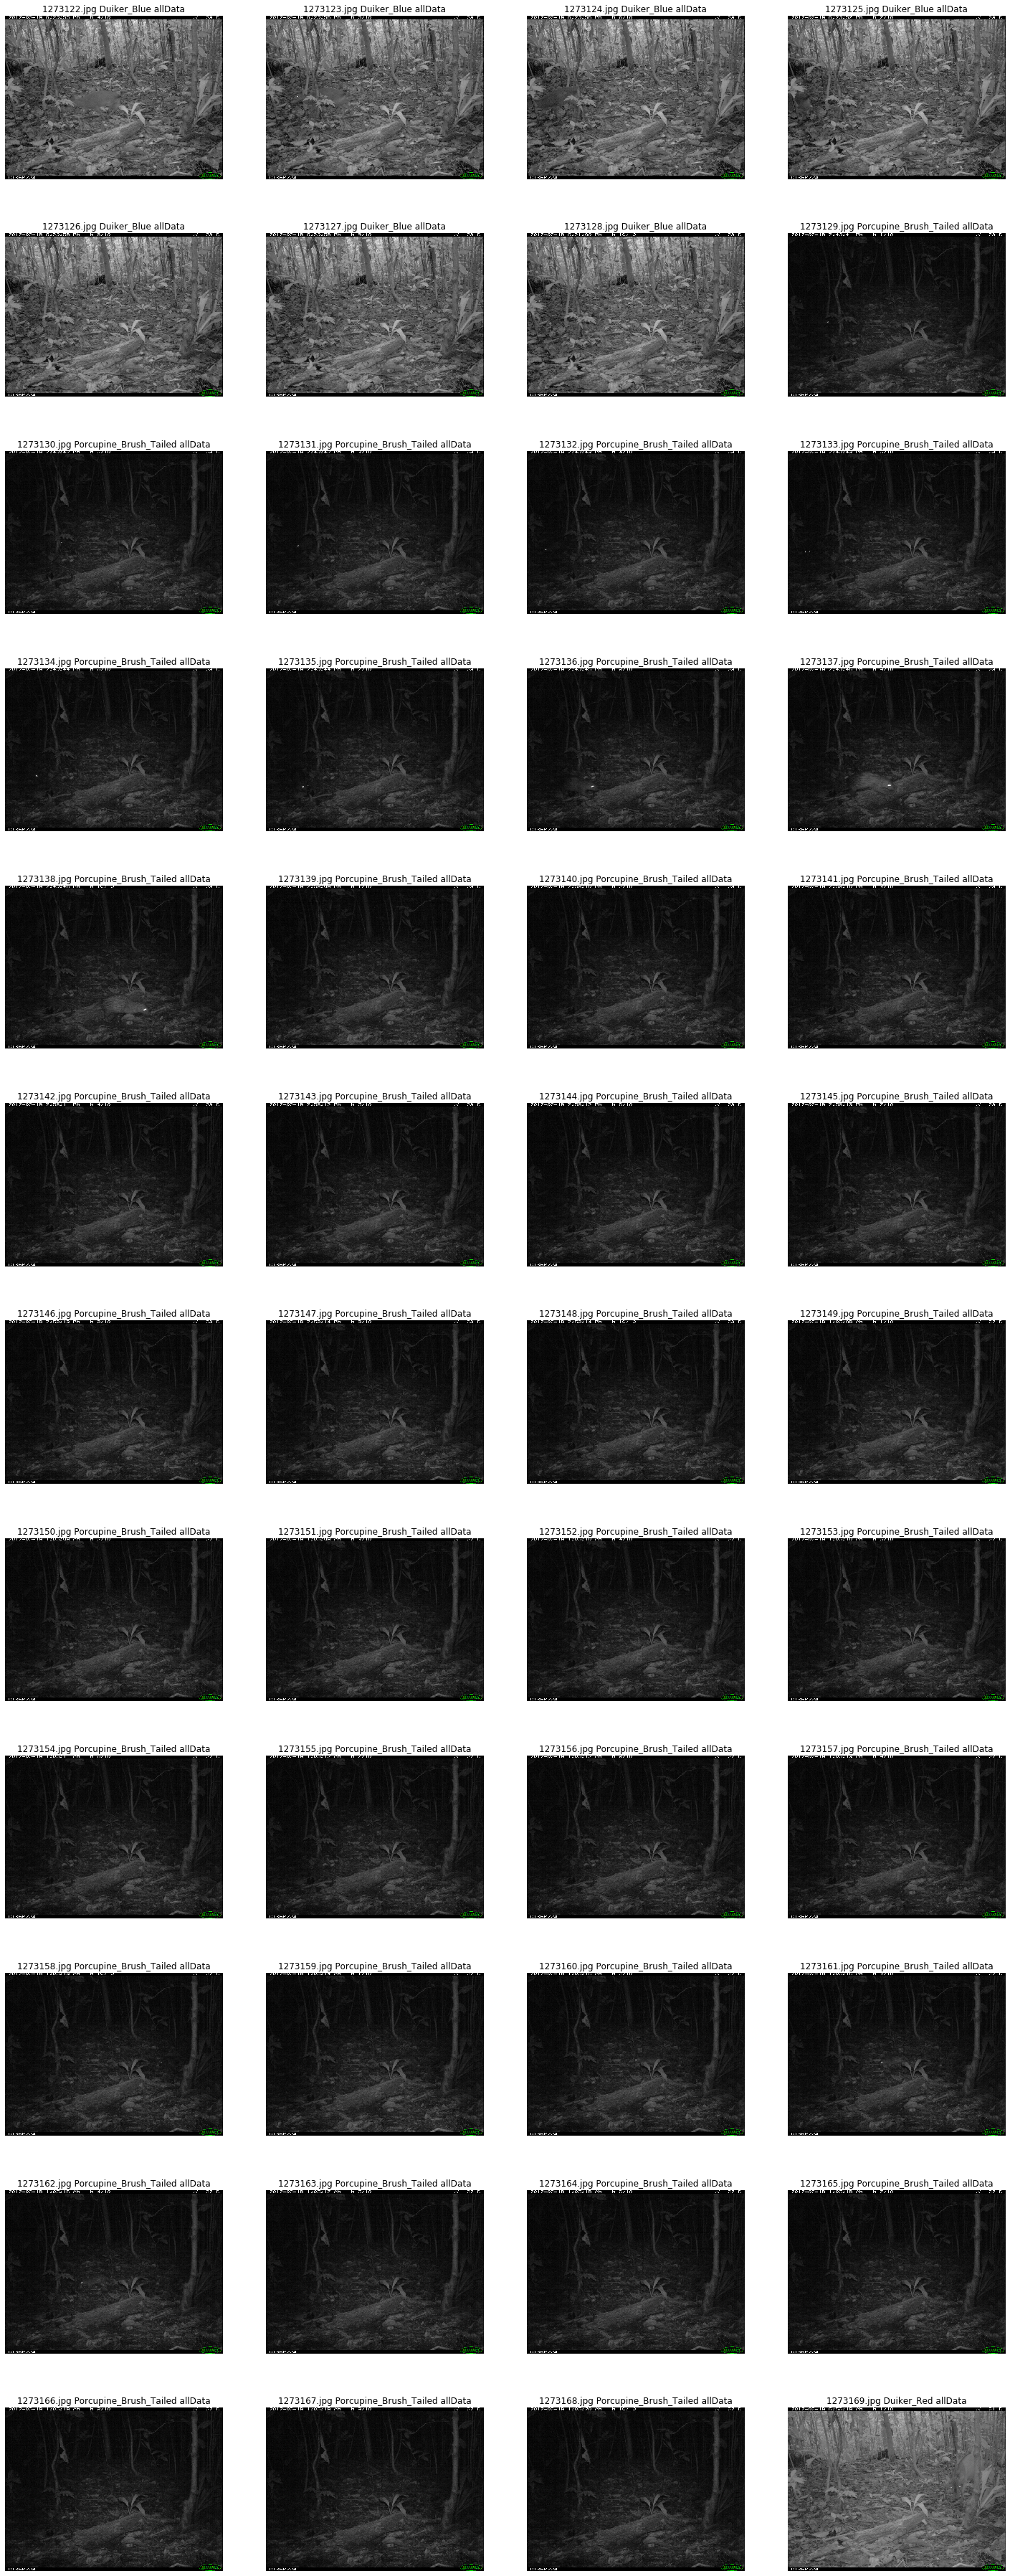

In [63]:
animal = "Duiker_Blue"
source = "allData"
start_id = 1273122

rows = 12
columns = 4
_,axs = plt.subplots(rows,columns,figsize=(25,rows*5.5))
for i,ax in enumerate(axs.flatten()):
    row = labels[labels.uniqueName == str(start_id + i) + ".jpg"]
    img_label = row.uniqueName.values[0]
    img = open_image(DATA_PATH / img_label)
    img.show(ax=axs[i//columns,i%columns], title=img_label + " " + row.species.values[0] + " " + row.main_folder.values[0])

In [6]:
sources = labels.main_folder.unique()

In [7]:
sources[2]

'Camera trap Nki National Park'

In [8]:
comp_df = labels[labels["main_folder"] == sources[0]] # Compressed Camera Trap Images
all_df = labels[labels["main_folder"] == sources[1]] # allData
nki_df = labels[labels["main_folder"] == sources[2]] # Camera trap Nki National Park

### Have location and datetime in filename

In [55]:
len(comp_df)

1185264

In [57]:
comp_df.species.nunique()

7

In [54]:
for i in comp_df.fullPath.tail(20):
    print(i)

D:/Compressed Camera Trap Images//Field season 3/T41 - EK009980 - 2017_06_08 06_27_20.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009981 - 2017_06_08 06_28_06.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009982 - 2017_06_08 06_28_19.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009983 - 2017_06_08 06_28_33.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009984 - 2017_06_08 06_29_21.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009985 - 2017_06_08 06_29_44.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009986 - 2017_06_08 06_30_40.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009987 - 2017_06_08 06_32_16.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009988 - 2017_06_08 06_33_15.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009989 - 2017_06_08 06_33_28.jpg
D:/Compressed Camera Trap Images//Field season 3/T41 - EK009990 - 2017_06_08 06_33_59.jpg
D:/Compres

### Robbie has exif

In [58]:
len(nki_df)

120740

In [59]:
nki_df.species.nunique()

24

In [60]:
for i in nki_df.fullPath.tail(20):
    print(i)

D:/Camera trap Nki National Park/C30/102EK113/05280368.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280369.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280370.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280371.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280372.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280373.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280374.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280375.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280376.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280377.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280378.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280379.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280380.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280381.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280382.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280383.JPG
D:/Camera trap Nki National Park/C30/102EK113/05280384.J

### No datetime data given

In [61]:
len(all_df)

344304

In [62]:
all_df.species.nunique()

29

In [64]:
for i in all_df.fullPath.tail(20):
    print(i)

D:/allData/NouabaleTEAM_345405.jpg
D:/allData/NouabaleTEAM_345406.jpg
D:/allData/NouabaleTEAM_345407.jpg
D:/allData/NouabaleTEAM_345408.jpg
D:/allData/NouabaleTEAM_345409.jpg
D:/allData/NouabaleTEAM_345410.jpg
D:/allData/NouabaleTEAM_345411.jpg
D:/allData/NouabaleTEAM_345412.jpg
D:/allData/NouabaleTEAM_345413.jpg
D:/allData/NouabaleTEAM_345414.jpg
D:/allData/NouabaleTEAM_345415.jpg
D:/allData/NouabaleTEAM_345416.jpg
D:/allData/NouabaleTEAM_345417.jpg
D:/allData/NouabaleTEAM_345418.jpg
D:/allData/NouabaleTEAM_345419.jpg
D:/allData/NouabaleTEAM_345420.jpg
D:/allData/NouabaleTEAM_345421.jpg
D:/allData/NouabaleTEAM_345422.jpg
D:/allData/NouabaleTEAM_345423.jpg
D:/allData/NouabaleTEAM_345424.jpg


In [67]:
# species missing from nki data
set(all_df.species.unique()) - set(nki_df.species.unique())

{'Buffalo_African',
 'Guineafowl_Black',
 'Guineafowl_Crested',
 'Rail_Nkulengu',
 'Rat_Giant'}

### Copy interesting pics for local inspection

In [70]:
import shutil

In [72]:
start_id = 1273129
end_id = 1273168
for i in range(start_id, end_id + 1):
    img_file = str(i) + ".jpg"
    shutil.copyfile(DATA_PATH / img_file, Path("/home/jupyter/inspect_pics") / img_file)

In [ ]:
# list_of_exif_dates = []
# i = 0
# for img_file in labels.uniqueName[:10000]:
#     path_name = DATA_PATH / img_file
#     f = open(path_name, 'rb')

#     # Return Exif tags
#     tags = exifread.process_file(f)
#     if "EXIF DateTimeOriginal" in tags:
#         list_of_exif_dates.append(tags["EXIF DateTimeOriginal"])
#     else:
#         list_of_exif_dates.append("no_exif_date")
#     if i % 1000 == 0:
#         print(f"round {i} complete")
#     i+=1

In [10]:
all_df.tail()

fullPath     species    n   uniqueName  \
1529563  D:/allData/NouabaleTEAM_345420.jpg  Duiker_Red  1.0  1529572.jpg   
1529564  D:/allData/NouabaleTEAM_345421.jpg  Duiker_Red  1.0  1529573.jpg   
1529565  D:/allData/NouabaleTEAM_345422.jpg  Duiker_Red  1.0  1529574.jpg   
1529566  D:/allData/NouabaleTEAM_345423.jpg  Duiker_Red  1.0  1529575.jpg   
1529567  D:/allData/NouabaleTEAM_345424.jpg  Duiker_Red  1.0  1529576.jpg   

        main_folder  
1529563     allData  
1529564     allData  
1529565     allData  
1529566     allData  
1529567     allData

In [13]:
all_df["source_folder"] = all_df.fullPath.str.extract('D:/[^/]*/([^_]*)', expand=True)
all_df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


fullPath      species    n   uniqueName  \
1185264  D:/allData/StephBrittainZSL_1.jpg  Duiker_Blue  1.0  1185273.jpg   
1185265  D:/allData/StephBrittainZSL_2.jpg  Duiker_Blue  1.0  1185274.jpg   
1185266  D:/allData/StephBrittainZSL_3.jpg  Duiker_Blue  1.0  1185275.jpg   
1185267  D:/allData/StephBrittainZSL_4.jpg   Duiker_Red  1.0  1185276.jpg   
1185268  D:/allData/StephBrittainZSL_5.jpg   Duiker_Red  1.0  1185277.jpg   

        main_folder     source_folder  
1185264     allData  StephBrittainZSL  
1185265     allData  StephBrittainZSL  
1185266     allData  StephBrittainZSL  
1185267     allData  StephBrittainZSL  
1185268     allData  StephBrittainZSL

In [16]:
all_df.source_folder.value_counts()

KorupTEAM                  172569
NouabaleTEAM               120352
LailaBahaaelDinPanthera     38368
StephBrittainZSL            13015
Name: source_folder, dtype: int64